# Data Preprocessing

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import pickle

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torchvision.disable_beta_transforms_warning()

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)[1:]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._get_images()
        self.class_count = self._get_class_count()
        self.images_splited_each_class = self._split_img_each_class()

    def _get_images(self):
        images = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            class_idx = self.class_to_idx[cls]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images
    
    def _get_class_count(self):
        class_count = {}
        for cls_name in self.class_to_idx.values():
            class_count[cls_name] = 0
        for key,value in self.images:
           class_count[value] += 1 
        return class_count
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        return img, label
    
    def _get_labels(self):
        return [i[1] for i in self.images]
    
    def _split_img_each_class(self):
        data_class_split = {}
        for i in self.class_to_idx.values():
            data_class_split[i] = []
        for i in self.class_to_idx.values():
            for j in range(len(self.images)):
                if self.images[j][-1] == i:
                    data_class_split[i].append(self.images[j])
        return data_class_split

In [3]:
class split_white_and_gray():
    def __init__(self,threshold=120) -> None:
        self.threshold = threshold

    def __call__(self,tensor):
        tensor = (tensor*255).to(torch.int64)

        # Apply thresholding
        white_matter = torch.where(tensor >= self.threshold,tensor,0)
        white_matter = (white_matter/255).to(torch.float64)
        gray_matter = torch.where(tensor < self.threshold,tensor,0)
        gray_matter = (gray_matter/255).to(torch.float64)
        tensor = (tensor/255).to(torch.float64)

        return white_matter, gray_matter,tensor

In [5]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    split_white_and_gray(120),
])

In [ ]:
Dataset = CustomDataset(root_dir='Dataset', transform=transform)

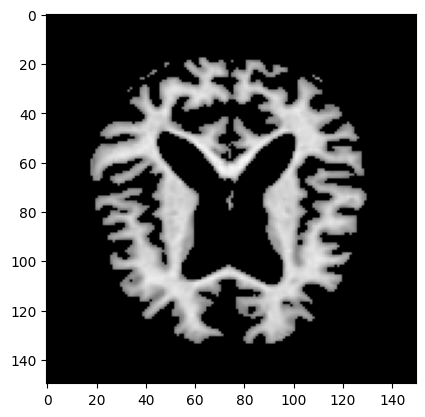

In [ ]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][0]),cmap='gray')
plt.show()

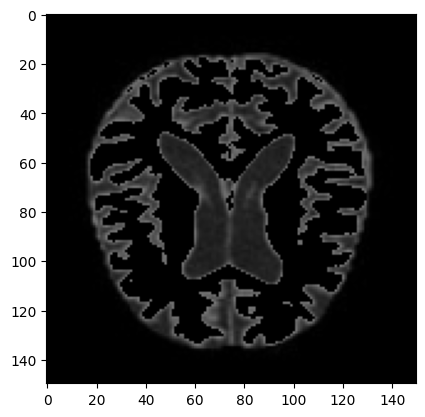

In [ ]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][1]),cmap='gray')
plt.show()

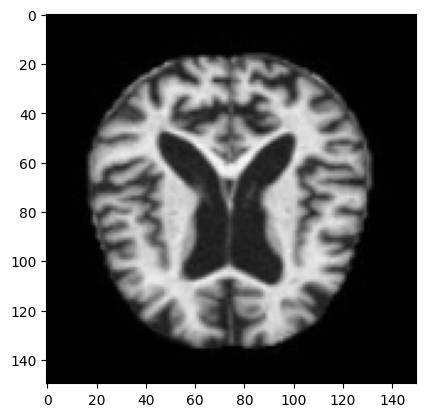

In [ ]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][2]),cmap='gray')
plt.show()

In [ ]:
from torch.utils.data import random_split

# Assuming you have a dataset named 'dataset' and it contains your data
dataset_size = len(Dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # Remaining 15% for testing

train_dataset, val_test_dataset = random_split(Dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

In [ ]:
def OverSample(Dataset):
    data = list(Dataset)
    class_count = {0:0, 1:0, 2:0, 3:0}
    for _, class_name in data:
        class_count[class_name] += 1

    # Calculate class weights for oversampling
    class_counts = list(class_count.values())
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

    # Assign weights to each sample based on its class
    
    weights = [class_weights[label] for _, label in data]

    # Create a WeightedRandomSampler to oversample minority classes
    sampler = WeightedRandomSampler(weights, 10000, replacement=True)

    return sampler

In [ ]:
batch_size=64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=OverSample(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=OverSample(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,)

# Train Function

In [ ]:
from torch.optim import lr_scheduler
import tqdm.notebook as tq
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def train(model: models, traindata: DataLoader, valdata: DataLoader, device=torch.device("mps" if torch.backends.mps.is_available() else "cpu"), num_epochs=50) -> tuple:
    # training
    # Loop for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = num_epochs
    train_loss_history = []
    train_accuracy_history = []
    train_precision_history = []
    train_recall_history = []
    train_f1_history = []
    train_specificity_history = []

    validation_loss_history = []
    validation_accuracy_history = []
    validation_precision_history = []
    validation_recall_history = []
    validation_f1_history = []
    validation_specificity_history = []

    for epoch in tq.tqdm(range(num_epochs), desc="Epoch num", position=0, leave=True):
        # Train set
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Val set
        val_running_loss = 0.0
        val_all_labels = []
        val_all_predictions = []

        # Use tqdm for progress visualization
        for i, data in enumerate(zip(traindata, valdata)):
            model.train()  # change mode to training

            train_set, val_set = data
            inputs, labels = train_set

            optimizer.zero_grad()

            # Move inputs and labels to device
            inputs, labels = [input.to(torch.float32).to(device) for input in inputs], labels.to(device)

            outputs = model(*inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track predictions for accuracy calculation
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            # Accumulate the loss
            running_loss += loss.item()

            # loss and acc on validation set
            model.eval()  # change mode to evaluation
            with torch.no_grad():
                val_inputs, val_labels = val_set
                val_inputs, val_labels = [val_input.to(torch.float32).to(device) for val_input in val_inputs], val_labels.to(device)

                val_outputs = model(*val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_predictions = torch.max(val_outputs, 1)
                val_all_labels.extend(val_labels.cpu().numpy())
                val_all_predictions.extend(val_predictions.cpu().numpy())

                val_running_loss += val_loss.item()

        scheduler.step()

        # Calculate metrics on training set
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

        conf_mat_train = confusion_matrix(all_labels, all_predictions)
        tn_train = np.sum(np.diag(conf_mat_train)) - np.diag(conf_mat_train)
        fp_train = np.sum(conf_mat_train, axis=0) - np.diag(conf_mat_train)
        fn_train = np.sum(conf_mat_train, axis=1) - np.diag(conf_mat_train)
        tp_train = np.diag(conf_mat_train)

        train_specificity = np.sum(tn_train / (tn_train + fp_train)) / len(tn_train)

        average_train_loss = running_loss / len(train_dataloader)
        train_loss_history.append(average_train_loss)
        train_accuracy_history.append(accuracy)
        train_precision_history.append(precision)
        train_recall_history.append(recall)
        train_f1_history.append(f1)
        train_specificity_history.append(train_specificity)


        # Calculate metrics on validation set
        val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_all_labels, val_all_predictions, average='weighted')

        conf_mat_val = confusion_matrix(val_all_labels, val_all_predictions)
        tn_val = np.sum(np.diag(conf_mat_val)) - np.diag(conf_mat_val)
        fp_val = np.sum(conf_mat_val, axis=0) - np.diag(conf_mat_val)
        fn_val = np.sum(conf_mat_val, axis=1) - np.diag(conf_mat_val)
        tp_val = np.diag(conf_mat_val)

        val_specificity = np.sum(tn_val / (tn_val + fp_val)) / len(tn_val)

        average_validation_loss = val_running_loss / len(val_dataloader)
        validation_loss_history.append(average_validation_loss)
        validation_accuracy_history.append(val_accuracy)
        validation_precision_history.append(val_precision)
        validation_recall_history.append(val_recall)
        validation_f1_history.append(val_f1)
        validation_specificity_history.append(val_specificity)

        # Print statistics for the epoch
        print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Training Loss   : {average_train_loss:.3f}  |  Training Accuracy   : {accuracy:.3f}  |  Training Precision   : {precision:.3f}  |  Training Recall   : {recall:.3f}  |  Training F1   : {f1:.3f}  |  Training Specificity   : {train_specificity:.3f}")
        print(f"Validation Loss : {average_validation_loss:.3f}  |  Validation Accuracy : {val_accuracy:.3f}  |  Validation Precision : {val_precision:.3f}  |  Validation Recall : {val_recall:.3f}  |  Validation F1 : {val_f1:.3f}  |  Validation Specificity : {val_specificity:.3f}")
        print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print()

    return {"Training":{"Training Loss":train_loss_history,"Training Accuracy":train_accuracy_history,"Training Precision":train_precision_history,\
                        "Training Recall": train_recall_history,"Training F1": train_f1_history,"Training Specificity":train_specificity_history}, \
           "Validation":{"Validation Loss":validation_loss_history,"Validation Accuracy": validation_accuracy_history, \
                         "Validation Precision":validation_precision_history, "Validation Recall":validation_recall_history,\
                             "Validation F1": validation_f1_history,"Validation Specificity": validation_specificity_history}}


In [ ]:
def count_parameters(model):
    if isinstance(model, nn.Module):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return None

# Define Model and Training

In [ ]:
import torch.nn as nn
import torchvision.models as models
from Resnet18 import *
from AlzheimerTriMatterNet import *

# Move the model to device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
AlzheimerModel = AlzheimerTriMatterNet().to(torch.float32).to(device)

In [ ]:
history = train(AlzheimerModel,train_dataloader,val_dataloader,num_epochs=30)

Epoch num:   0%|          | 0/30 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/30
Training Loss   : 1.057  |  Training Accuracy   : 0.680  |  Training Precision   : 0.675  |  Training Recall   : 0.680  |  Training F1   : 0.673  |  Training Specificity   : 0.870
Validation Loss : 1.371  |  Validation Accuracy : 0.363  |  Validation Precision : 0.366  |  Validation Recall : 0.363  |  Validation F1 : 0.343  |  Validation Specificity : 0.651
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 2/30
Training Loss   : 0.992  |  Training Accuracy   : 0.745  |  Training Pr

In [ ]:
torch.save(AlzheimerModel, 'AlzheimerModel.pth')

## Eval

In [ ]:
import torch
from sklearn.metrics import accuracy_score

AlzheimerModel.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = [testinput.to(torch.float32).to(device) for testinput in test_inputs] , test_labels.to(device)

        test_outputs = AlzheimerModel(*test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tqdm.notebook as tq

AlzheimerModel.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = [testinput.to(torch.float32).to(device) for testinput in test_inputs], test_labels.to(device)

        test_outputs = AlzheimerModel(*test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)

# Calculate precision, recall, F1 score, and specificity
precision = precision_score(test_all_labels, test_all_predictions, average='weighted')
recall = recall_score(test_all_labels, test_all_predictions, average='weighted')
f1 = f1_score(test_all_labels, test_all_predictions, average='weighted')

# Calculate specificity using confusion matrix
conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
specificity = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average Test Loss: {average_test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity}")


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.8844
Average Test Loss: 0.8575
Precision: 0.8848
Recall: 0.8844
F1 Score: 0.8845
Specificity: [0.9        0.86614173 0.87951807 0.89205703]


In [ ]:
import pandas as pd
train_history = pd.DataFrame(history['Training'])
val_history = pd.DataFrame(history['Validation'])
train_history.to_csv('train_history.csv')
val_history.to_csv('val_history.csv')

In [ ]:
summary = pd.DataFrame({
    "Loss" : [train_history['Training Loss'].iloc[-1],val_history['Validation Loss'].iloc[-1],average_test_loss],
    "Accuracy" : [train_history['Training Accuracy'].iloc[-1],val_history['Validation Accuracy'].iloc[-1],test_accuracy],
    "Precision" : [train_history['Training Precision'].iloc[-1],val_history['Validation Precision'].iloc[-1],precision],
    "Recall" : [train_history['Training Recall'].iloc[-1],val_history['Validation Recall'].iloc[-1],recall],
    "F1" : [train_history['Training F1'].iloc[-1],val_history['Validation F1'].iloc[-1],f1],
    "Specificity" : [train_history['Training Specificity'].iloc[-1],val_history['Validation Specificity'].iloc[-1],specificity[0]],
})
summary = summary.set_axis(['Train', 'Validation', 'Test'])
summary.to_csv('model_summary.csv')
summary

,Loss,Accuracy,Precision,Recall,F1,Specificity
Train,0.769268,0.976500,0.976548,0.976500,0.976463,0.992101
Validation,0.874749,0.882200,0.891530,0.882200,0.884323,0.958633
Test,0.857506,0.884375,0.884839,0.884375,0.884522,0.900000


# Grad-cam

In [475]:
# Load an example image for visualization (replace 'example.jpg' with your image path)
image_path = '/Users/ohm/Desktop/Alzheimer Project/Grad-cam/Dataset/Moderate_Demented/moderate_20.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    split_white_and_gray(120),
])
white_matter_tensor, gray_matter_tensor, origin_tensor = transform(image)
white_matter_tensor, gray_matter_tensor, origin_tensor = white_matter_tensor.unsqueeze(0).to(torch.float32),\
    gray_matter_tensor.unsqueeze(0).to(torch.float32),\
    origin_tensor.unsqueeze(0).to(torch.float32)

In [476]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def showcam_withoutmask(original_image, grayscale_cam):
    # Assuming you have two tensors: 'original_image' and 'cam_mask'
    # Make sure both tensors are on the CPU
    original_image = torch.squeeze(original_image).cpu()  # torch.Size([3, 150, 150])
    cam_mask = grayscale_cam.cpu()  # torch.Size([1, 150, 150])

    # Convert the tensors to NumPy arrays
    original_image_np = original_image.numpy()
    cam_mask_np = cam_mask.numpy()

    # Apply the mask to the original image
    masked_image = original_image_np * cam_mask_np

    # Normalize the masked_image
    masked_image_norm = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image))

    # Plot the original image, mask, and the overlay
    plt.figure(figsize=(14, 4))

    plt.subplot(141)
    plt.imshow(original_image_np.transpose(1, 2, 0))  # Assuming your original image is in (C, H, W) format
    plt.title('Original Image')

    plt.subplot(142)
    plt.imshow(cam_mask_np[0], cmap='jet')  # Assuming your mask is grayscale
    plt.title('CAM Mask')

    plt.subplot(143)
    plt.imshow(masked_image_norm.transpose(1, 2, 0))  # Assuming your original image is in (C, H, W) format
    plt.title('Overlay (Normalized)')

    plt.show()


In [477]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

def showcam_withmask(img_tensor: torch.Tensor,
                            mask_tensor: torch.Tensor,
                            use_rgb: bool = False,
                            colormap: int = cv2.COLORMAP_JET,
                            image_weight: float = 0.5):
    """ This function overlays the CAM mask on the image as a heatmap and directly plots the result.
    By default, the heatmap is in BGR format.

    :param img_tensor: The base image tensor in PyTorch format.
    :param mask_tensor: The CAM mask tensor in PyTorch format.
    :param use_rgb: Whether to use an RGB or BGR heatmap; set to True if 'img_tensor' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    """
    # Convert PyTorch tensors to NumPy arrays
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mask = mask_tensor.cpu().numpy()

    # Convert the mask to a single-channel image
    mask_single_channel = np.uint8(255 * mask[0])

    heatmap = cv2.applyColorMap(mask_single_channel, colormap)

    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception("The input image should be in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(f"image_weight should be in the range [0, 1]. Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)

    # Plot the original image, CAM mask, and overlay
    plt.figure(figsize=(10, 4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(mask[0], cmap='jet')
    plt.title('CAM Mask')

    plt.subplot(133)
    plt.imshow(cam)
    plt.title('Overlay')

    plt.show()


## origin

In [478]:
import torch
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from AlzheimerTriMatterNet import *
import matplotlib.pyplot as plt

# Load your trained model (replace 'YourModel' with the actual model class you have)
model_grad = torch.load('AlzheimerModel.pth')
# Load the trained weights
model_grad = model_grad.resnet18_model
model_grad.eval()

# Define the GradCAM object
target_layer = [model_grad.layer4[-1]] # Specify the layer you want to visualize
gradcam = GradCAM(model=model_grad, target_layers=target_layer)
targets = [ClassifierOutputTarget(100)]
grayscale_cam = gradcam(input_tensor=origin_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
grayscale_cam = torch.tensor(grayscale_cam)

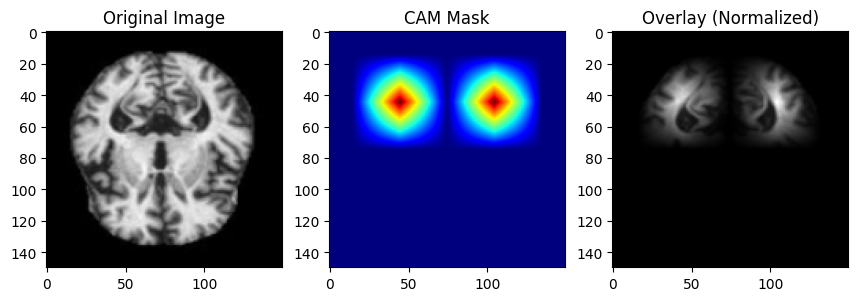

In [479]:
showcam_withoutmask(origin_tensor,grayscale_cam)

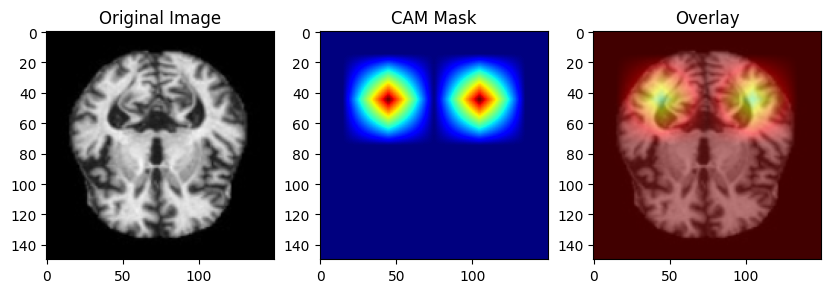

In [480]:
showcam_withmask(torch.squeeze(origin_tensor),grayscale_cam,)

## white

In [481]:
# Load your trained model (replace 'YourModel' with the actual model class you have)
model_grad = torch.load('AlzheimerModel.pth')
# Load the trained weights
model_grad = model_grad.whitematter_resnet18_model
model_grad.eval()

# Define the GradCAM object
target_layer = [model_grad.layer4[-1]] # Specify the layer you want to visualize
gradcam = GradCAM(model=model_grad, target_layers=target_layer)
targets = [ClassifierOutputTarget(100)]
grayscale_cam = gradcam(input_tensor=white_matter_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
grayscale_cam = torch.tensor(grayscale_cam)

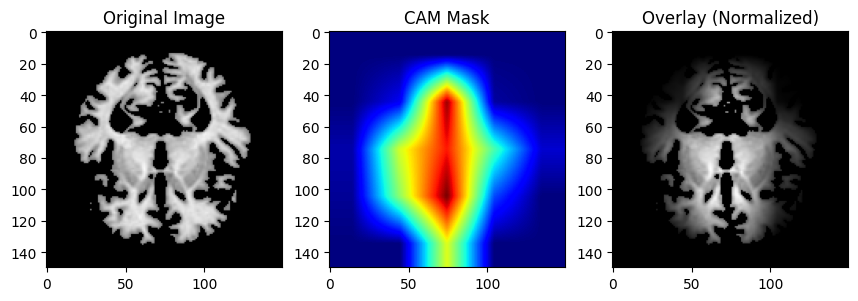

In [482]:
showcam_withoutmask(white_matter_tensor,grayscale_cam)

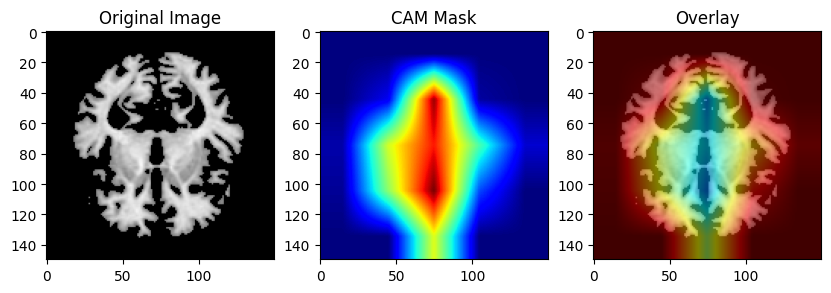

In [483]:
showcam_withmask(torch.squeeze(white_matter_tensor),grayscale_cam)

## gray

In [484]:
# Load your trained model (replace 'YourModel' with the actual model class you have)
model_grad = torch.load('AlzheimerModel.pth')
# Load the trained weights
model_grad = model_grad.graymatter_resnet18_model
model_grad.eval()

# Define the GradCAM object
target_layer = [model_grad.layer4[-1]] # Specify the layer you want to visualize
gradcam = GradCAM(model=model_grad, target_layers=target_layer)
targets = [ClassifierOutputTarget(100)]
grayscale_cam = gradcam(input_tensor=gray_matter_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
grayscale_cam = torch.tensor(grayscale_cam)

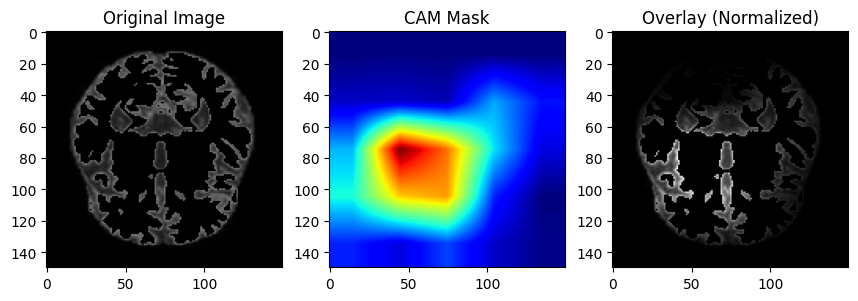

In [485]:
showcam_withoutmask(gray_matter_tensor,grayscale_cam)

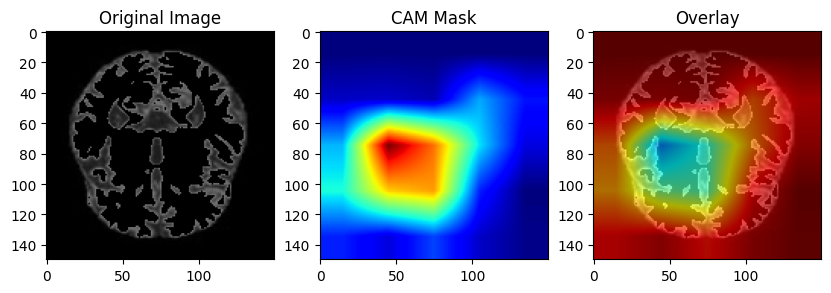

In [486]:
showcam_withmask(torch.squeeze(gray_matter_tensor),grayscale_cam)